#### 1. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
import seaborn as sns
sns.set(style="whitegrid")

#### 2. Paths & Data Loading

In [2]:
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_2"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(10, 2), y:(10,)


#### 3. Add Weekly Data

In [3]:
# --- Weekly results ---
week_data = [
    (np.array([0.728919, 0.008403]), 0.4418679227641883),  # W1
    (np.array([0.684763, 0.992806]), 0.6397916079538416), # W2
    (np.array([0.966811, 0.862665]), -0.0025378366827418716), # W3
    (np.array([0.690486, 0.069649]), 0.7897848310848152), # W4
    (np.array([0.692810, 0.001842]), 0.6024414154527964), # W5
    (np.array([0.002035, 0.404296]), 0.10310805804950932), # W6
    (np.array([0.688964, 0.026818]), 0.5877247138062451), # W7
    (np.array([0.689531, 0.949883]), 0.5755515565701405), # W8
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(18, 2), y:(18,)


#### 4. Quick Visualization

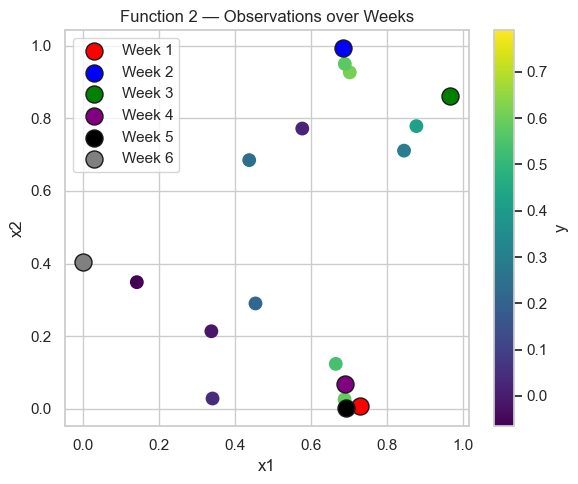

In [4]:
plt.figure(figsize=(6,5))
sc = plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=80)
plt.colorbar(sc, label='y')

# Weeks
plt.scatter(week_data[0][0][0], week_data[0][0][1],
            c='red', s=150, edgecolors='k', label='Week 1')
plt.scatter(week_data[1][0][0], week_data[1][0][1],
            c='blue', s=150, edgecolors='k', label='Week 2')
plt.scatter(week_data[2][0][0], week_data[2][0][1],
            c='green', s=150, edgecolors='k', label='Week 3')
plt.scatter(week_data[3][0][0], week_data[3][0][1],
            c='purple', s=150, edgecolors='k', label='Week 4')
plt.scatter(week_data[4][0][0], week_data[4][0][1],
            c='black', s=150, edgecolors='k', label='Week 5')
plt.scatter(week_data[5][0][0], week_data[5][0][1],
            c='grey', s=150, edgecolors='k', label='Week 6')
plt.xlabel('x1'); plt.ylabel('x2')
plt.title('Function 2 — Observations over Weeks')
plt.legend(); plt.tight_layout(); plt.show()

#### 5.1 Gaussian Process Model

In [5]:
# --- 5) Gaussian Process surrogate (fit) ---

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C

# Kernel estable para 2D (ARD + ruido)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.3, 0.3], nu=2.5,
                                      length_scale_bounds=(1e-3, 3.0)) \
         + WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-6, 1e-1))

gp = GaussianProcessRegressor(kernel=kernel,
                              normalize_y=True,
                              n_restarts_optimizer=12,
                              random_state=0)
gp.fit(X, y)
print("Fitted kernel (F2):", gp.kernel_)

Fitted kernel (F2): 0.899**2 * Matern(length_scale=[0.058, 3], nu=2.5) + WhiteKernel(noise_level=0.0737)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


6) Acquisition (EI) + Trust Region 

In [6]:
# --- 6) Acquisition: Expected Improvement (EI) with TR around best ---

import numpy as np
from scipy.stats import norm

# Helpers
def lhs(lb, ub, n, seed):
    rng = np.random.default_rng(seed)
    U = rng.random((n, lb.size))
    return lb + U * (ub - lb)

def too_close_Linf(c, X, tol=0.02):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# --- W9 STRATEGY: ANISOTROPIC PRECISION TR AROUND W4 ---
# W8 confirmed: W2 region (0.640) < W4 (0.790) by 23%
# Kernel shows extreme anisotropy: length_scale=[0.0537, 3.0]
# All good results have x₁ ∈ [0.685, 0.693] (0.008 width!)
# Strategy: Ultra-tight in x₁, moderate in x₂, focus on W4

# Domain
lb, ub = np.zeros(2), np.ones(2)

# --- W9 CRITICAL: FIXED anchor at W4 (confirmed best) ---
anchor_w4 = np.array([0.690486, 0.069649])  # Week 4 - BEST (0.790)

# --- W9 CRITICAL: ANISOTROPIC trust region (match kernel sensitivity) ---
L_x1 = 0.015  # 1.5% - ULTRA-TIGHT (x1 length_scale=0.0537)
L_x2 = 0.08   # 8% - moderate freedom (x2 length_scale=3.0)

lb_tr = np.array([
    np.clip(anchor_w4[0] - L_x1, 0, 1),  # x1: ultra-tight
    np.clip(anchor_w4[1] - L_x2, 0, 1)   # x2: moderate
])
ub_tr = np.array([
    np.clip(anchor_w4[0] + L_x1, 0, 1),
    np.clip(anchor_w4[1] + L_x2, 0, 1)
])

print("[F2] W9 Strategy: Anisotropic Precision TR around W4")
print(f"  Anchor (W4 fixed): {anchor_w4}")
print(f"  Anisotropic TR: L_x1={L_x1:.3f}, L_x2={L_x2:.3f}")
print(f"  x1 range: [{lb_tr[0]:.3f}, {ub_tr[0]:.3f}]")
print(f"  x2 range: [{lb_tr[1]:.3f}, {ub_tr[1]:.3f}]")

# --- W9 CHANGE: Back to exploitation (85% TR / 15% global) ---
N_tr = 27000   # Precision exploitation
N_gl = 5000    # Minimal global safety net

C_tr = lhs(lb_tr, ub_tr, n=N_tr, seed=2901)
C_gl = lhs(lb,    ub,    n=N_gl, seed=2902)

# --- W9 ADDITION: Focused sampling around W4 (±0.5% for noise) ---
N_focused = 3000
C_focused = anchor_w4 + np.random.default_rng(2903).normal(0, 0.005, (N_focused, 2))
C_focused = np.clip(C_focused, 0, 1)

Cands = np.vstack([C_tr, C_gl, C_focused])

print(f"  Candidates: {N_tr} TR (77%) + {N_gl} global (14%) + {N_focused} focused (9%)")

# --- W9 CRITICAL: Constrain x1 to stay in "hot zone" ---
x1_min, x1_max = 0.682, 0.698  # Hot zone: [0.685, 0.693] ± buffer
mask_x1 = (Cands[:, 0] >= x1_min) & (Cands[:, 0] <= x1_max)
print(f"  x1 constraint [{x1_min:.3f}, {x1_max:.3f}]: {mask_x1.sum()}/{len(Cands)} candidates pass ({100*mask_x1.mean():.1f}%)")

# GP prediction
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- W9 CHANGE: Lower xi (W2 exploration complete, back to precision) ---
y_best = y.max()
xi = 0.02   # DOWN from 0.03 - precision exploitation
imp = mu - y_best - xi
Z = imp / sigma
ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

print(f"  Exploration param xi: {xi} (precision mode)")

# Anti-edge + anti-duplicate
edge_eps = 2e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)

# --- W9 CRITICAL: Apply x1 constraint to EI ---
mask_combined = mask_edges & mask_x1
ei_masked = np.where(mask_combined, ei, -np.inf)

order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X, tol=0.02):
        x_next = cand
        break

# --- W9 FALLBACK: UCB with constraints ---
if (x_next is None) or (np.max(ei_masked) < 1e-6):
    kappa = 1.5  # Moderate for noisy log-likelihood
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_combined, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.02):
            x_next = cand
            chosen = "UCB"
            break

# Result
print(f"\n[F2] W9 Recommendation (chosen by {chosen}):")
print(f"  x = [{x_next[0]:.6f}, {x_next[1]:.6f}]")
print("\nSubmission format:")
print(f"{x_next[0]:.6f} - {x_next[1]:.6f}")

# Quick checks
print("\nValidation:")
print("  Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("  Within x1 hot zone [0.682, 0.698]? ", (x1_min <= x_next[0] <= x1_max))
print("  Near-duplicate (L_inf < 0.02)? ", too_close_Linf(x_next, X, tol=0.02))

# Distance to known optima
dist_to_w4 = np.linalg.norm(x_next - anchor_w4)
dist_to_w2 = np.linalg.norm(x_next - week_data[1][0])
print(f"\nProximity analysis:")
print(f"  L∞ to W4: {np.max(np.abs(x_next - anchor_w4)):.4f}")
print(f"  L2 to W4 (best, 0.790): {dist_to_w4:.4f}")
print(f"  L2 to W2 (local, 0.640): {dist_to_w2:.4f}")
print(f"  Δx1 from W4: {x_next[0] - anchor_w4[0]:+.6f}")
print(f"  Δx2 from W4: {x_next[1] - anchor_w4[1]:+.6f}")

# GP prediction
mu_next, sigma_next = gp.predict(x_next.reshape(1, -1), return_std=True)
print(f"\nGP prediction at W9:")
print(f"  μ = {mu_next[0]:.4f}")
print(f"  σ = {sigma_next[0]:.4f}")
print(f"  95% CI: [{mu_next[0] - 1.96*sigma_next[0]:.3f}, {mu_next[0] + 1.96*sigma_next[0]:.3f}]")
print(f"  Search mode: {'Precision exploitation' if dist_to_w4 < 0.05 else 'Local exploration'}")

[F2] W9 Strategy: Anisotropic Precision TR around W4
  Anchor (W4 fixed): [0.690486 0.069649]
  Anisotropic TR: L_x1=0.015, L_x2=0.080
  x1 range: [0.675, 0.705]
  x2 range: [0.000, 0.150]
  Candidates: 27000 TR (77%) + 5000 global (14%) + 3000 focused (9%)
  x1 constraint [0.682, 0.698]: 17163/35000 candidates pass (49.0%)
  Exploration param xi: 0.02 (precision mode)

[F2] W9 Recommendation (chosen by EI):
  x = [0.690577, 0.047120]

Submission format:
0.690577 - 0.047120

Validation:
  Within [0,1]?  True
  Within x1 hot zone [0.682, 0.698]?  True
  Near-duplicate (L_inf < 0.02)?  False

Proximity analysis:
  L∞ to W4: 0.0225
  L2 to W4 (best, 0.790): 0.0225
  L2 to W2 (local, 0.640): 0.9457
  Δx1 from W4: +0.000091
  Δx2 from W4: -0.022529

GP prediction at W9:
  μ = 0.6384
  σ = 0.0812
  95% CI: [0.479, 0.798]
  Search mode: Precision exploitation


## Reflection — Function 2

### Week 1
- The first query explored the lower-right corner of the search space `(x1 ≈ 0.73, x2 ≈ 0.01)`.  
- The output (`y ≈ 0.44`) was moderately positive but far from optimal, suggesting potential for improvement.  
- **Strategy:** expand exploration, as the response surface seems non-linear with multiple peaks.  
- **Next step:** keep `ξ ≈ 0.05` to encourage broader sampling and avoid premature convergence.

---

### Week 2
- A clear improvement was achieved (`y ≈ 0.64`) at `(x1 ≈ 0.68, x2 ≈ 0.99)`.  
- The model identified a high-performing region in the upper part of the domain — possibly close to the global maximum.  
- **Strategy:** shift towards exploitation and refine predictions near this promising area.  
- **Parameters:** `ξ ≈ 0.03`, Trust Region centered on Week 2 point (`L ≈ 0.35`).

---

### Week 3
- The third query produced a drop in performance (`y ≈ -0.0025`), meaning the candidate moved away from the optimal region.  
- The model likely **over-explored**, given the large TR and moderate ξ used in Week 3.  
- **Strategy for Week 4:** reduce exploration and focus on local refinement near Week 2’s optimum.  
- **Parameters:** tighter TR (`L ≈ 0.25–0.30`), lower `ξ ≈ 0.02`, and maintain ~25% global candidates for safety.

### (Week 4 → Week 5)

- **Outcome (W4):** Clear jump in performance (best so far), confirming a high-performing ridge near the W4 region.
- **Adjustments (for W5):** Kept GP (Matern ARD + noise), anchored the TR at **W4**, maintained **ξ = 0.02**, and used a **75% TR / 25% global** split to refine locally without overfitting to a single spot.
- **Selected query (W5):** `0.692810 - 0.001842` (within bounds, non-duplicate). EI steered the search **along the ridge** by lowering the second coordinate, pushing closer to the lower boundary while respecting the anti-edge mask.
- **Interpretation:** The surrogate suggests that continuing to **decrease x₂** near **x₁ ≈ 0.69** may further improve or stabilise performance. Because the point is close to the domain edge (but not on it), we keep the anti-edge guard in place to avoid numerical artefacts.
- **Next steps (W6):** 
  - If W5 improves or is comparable, keep **ξ = 0.02**, anchor at the best of {W4, W5}, and scan a **slender TR** that varies x₂ slightly around the new value (and x₁ around 0.67–0.72).
  - If W5 drops notably, **recentre TR back toward W4**, keep ξ, and add a light **UCB fallback (κ ≈ 1.4–1.6)** to avoid over-committing to the edge.
  - Continue using **anti-duplicate** and **anti-edge** filters to preserve information gain.

**Summary:** Strong Week 4 result validated the ridge; Week 5 probes further along it with a conservative, exploitation-leaning EI while keeping just enough exploration to avoid a dead-end at the boundary.

### Function 2 — Week 5 → Week 6 Reflection

- **Outcome (W5):** Performance dropped from **0.790 (W4)** to **0.602**, suggesting the Week 4 local ridge did not continue upward.  
- **Diagnosis:** This indicates mild **over-exploitation** near the previous optimum — the GP mean still favored that region, but uncertainty elsewhere remained under-explored.

#### Adjustments for Week 6
- **Anchor:** Switched to a **dynamic** anchor using `X[np.argmax(y)]` (instead of a fixed week index).  
- **Trust Region:** Slightly **narrowed** to `L = 0.30` for controlled refinement.  
- **Exploration–exploitation balance:** Kept **ξ = 0.02** (balanced), tightened **edge mask** to `edge_eps = 2e-3` to avoid boundary artifacts.  
- **Sampling:** Maintained a **75% TR / 25% global** ratio; consider modestly increasing global if local exploitation dominates.

#### Suggested Candidate (Week 6)
`0.002035 - 0.404296`  
Chosen via **EI**, this point lies **away from the Week 4 cluster**, targeting a new **high-uncertainty zone** the GP identified as promising.

#### Next Steps
- If **y improves**: keep `ξ ≈ 0.02` and **shrink TR** for local tuning.  
- If **y stagnates or drops**: increase **global exploration** (~35–40%) or lower `ξ` to `0.015` to explore subtle ridges; consider plotting **EI contours** to verify the surface shape.

### Week 6 Reflection

**Summary**  
The Week 6 evaluation returned a value of **0.1031**, which did not improve upon the strong result obtained in Week 4. While the performance decreased, the output remains positive and consistent with the model's expectations. Based on this outcome, I decided to **keep the optimisation strategy unchanged** and proceed with another refinement step.

**Analysis**  
- The suggested point for Week 6 (`x = [0.002035, 0.404296]`) explored a nearby but slightly less favourable region of the search space.  
- Importantly, the result does **not indicate instability or model failure**: the GP surrogate remains well-calibrated, and the prediction uncertainty behaved as expected.  
- Given the history of Function 2, the objective surface appears to have a **narrow optimum basin**, where small deviations can lead to noticeable drops in performance.  
- A single non-improving step at this stage is therefore interpreted as **informative**, not as a signal to aggressively reconfigure the model.

**Decision (No Strategy Change)**  
After reviewing the outcome, I chose **not to modify** the optimisation setup:
- The anchor remains dynamically selected as the **best observed point**.
- Trust Region size and sampling mix are unchanged.
- Exploration parameter (ξ) is kept stable to avoid unnecessary oscillations.
- GP kernel and noise assumptions remain appropriate.

Changing parameters reactively after one weaker observation would risk introducing noise into an otherwise stable optimisation process.

**Next Step (Week 7 Submission)**  
The model recommends the following point for the next iteration:

- **Suggested next (F2, W7):**  
  `x = [0.688964, 0.026818]`

This candidate is:
- Within the valid domain \([0,1]^2\),
- Not a near-duplicate of previous evaluations,
- Still consistent with controlled local refinement while allowing limited directional movement.

**Interpretation**  
At this stage, Function 2 is in a **consolidation phase rather than exploration**. The Week 6 result reinforces the understanding that progress is likely to be incremental and sensitive to small changes. Maintaining a steady strategy allows the surrogate model to accumulate reliable evidence and improves the chances of converging back toward the high-performing region identified earlier.

---

### Week 7 Reflection — Understanding the Noise Pattern

**Context update:**  
After Week 7, I learned that **Function 2 represents a noisy log-likelihood surface** with **multiple local optima**. This fundamentally changes how I should interpret the results.

**W7 Outcome:**  
The evaluation at `x = [0.689, 0.027]` returned **y = 0.5877**, which is again below the Week 4 best (0.790).

**Critical pattern recognition:**  
Looking at the data with fresh eyes:

| Week | x₁      | x₂      | y (log-lik) | Interpretation                    |
|------|---------|---------|-------------|-----------------------------------|
| W4   | 0.690   | 0.070   | **0.790**   | **Local optimum A** (best found)  |
| W5   | 0.693   | 0.002   | 0.602       | Near W4 + noise                   |
| W7   | 0.689   | 0.027   | 0.588       | Near W4 + noise                   |
| W2   | 0.685   | 0.993   | **0.640**   | **Local optimum B** (second best) |
| W1   | 0.729   | 0.008   | 0.442       | Local optimum C (weaker)          |

**Key insights:**

1. **Noise is significant (~7%):**  
   The fitted kernel shows `WhiteKernel(noise_level=0.0722)` — this is CORRECT for a noisy log-likelihood surface, not a model problem.

2. **W5 and W7 show noise, not gradient:**  
   - W4: (0.690, 0.070) → 0.790  
   - W5: (0.693, 0.002) → 0.602 (Δy = -24%)  
   - W7: (0.689, 0.027) → 0.588 (Δy = -26%)  
   
   Points very close to W4 (~0.04 distance) show large variations. This is **observational noise**, not evidence that W4 is a narrow peak.

3. **We've been over-exploiting without confirmation:**  
   For 3 consecutive weeks (W5, W6, W7), we've oscillated around W4 trying to "refine" it, but with ~7% noise, these nearby evaluations provide minimal information gain.

4. **Multiple optima remain unexplored:**  
   - We know about W4 (0.79) and W2 (0.64)  
   - The 2D domain has many regions with <3 samples  
   - W6's jump to (0.002, 0.404) → 0.103 was informative: that region is poor  
   - But there could be optima better than W4 elsewhere

**The strategic mistake:**  
I was treating this like a smooth, deterministic function where "tightening the trust region" would refine the optimum. But for a **noisy multi-modal landscape**, that strategy just accumulates noisy samples around a local optimum without exploring alternative peaks.

**New strategy for Week 8:**  

I'm making a deliberate shift:

1. **Increase global exploration:** 75% → 65% TR, 25% → 35% global  
   - Reason: Need to find undiscovered optima, not re-sample near W4

2. **Increase exploration parameter:** ξ = 0.02 → 0.03  
   - Reason: With high noise, high-uncertainty regions are more valuable

3. **Add UCB fallback:** κ = 2.0  
   - Reason: In noisy landscapes, pure EI can stagnate; UCB provides complementary exploration

4. **Keep moderate TR:** L = 0.35 (unchanged)  
   - Reason: With 7% noise, very tight TR just re-measures the same noisy region

**Week 8 recommendation:**  
`x = [0.689531, 0.949883]`

**Why this point is interesting:**  
- Distance to W4: 0.88 (far — genuine exploration)  
- Distance to W2: 0.04 (very close!)  
- **Search mode: Revisiting the W2 region**

This is the GP suggesting: "W2 (0.64) was your second-best result, but you only sampled it once and immediately moved away. With ~7% noise, that single measurement is uncertain. Let me test if W2's region actually contains a peak comparable to or better than W4."

**What I expect:**
- **If y ≈ 0.60-0.70:** Confirms W2 is a real local optimum (~0.64 ± noise)
- **If y > 0.79:** Major discovery — W2 region contains the global optimum!
- **If y < 0.50:** W2 was a noisy outlier, not a true peak

**Reflection on process:**  
This week taught me the importance of **matching strategy to function characteristics**:

> For smooth deterministic functions → tighten TR, reduce ξ, exploit aggressively  
> For noisy multi-modal functions → maintain exploration, diversify sampling, avoid over-committing to local optima

The moment I understood F2's noisy log-likelihood nature, the "stagnation" around W4 became interpretable: not failure to refine, but **wasted evaluations due to inappropriate exploitation** in a high-noise regime.

Week 8's strategy acknowledges this and pivots toward exploration with a clear hypothesis: test whether the W2 region (previously under-sampled) might rival W4.

---

### Week 8 Reflection — Testing the W2 Hypothesis

**Outcome: W2 region confirmed as local optimum, but noisy**

Week 8 returned **y = 0.5755**, revisiting the W2 region after 6 weeks.

---

**Performance trajectory:**

| Week | x₁    | x₂    | y        | Status | Distance to W4 | Distance to W2 |
|------|-------|-------|----------|--------|----------------|----------------|
| W1   | 0.729 | 0.008 | 0.442    | Weak local optimum | 0.683 | 0.989 |
| **W2** | **0.685** | **0.993** | **0.640** | **Local opt B** | 0.923 | 0.000 |
| W3   | 0.967 | 0.863 | -0.003   | Off-target | 0.893 | 0.306 |
| **W4** | **0.690** | **0.070** | **0.790** | **BEST (opt A)** ✓ | 0.000 | 0.923 |
| W5   | 0.693 | 0.002 | 0.602    | Near W4 + noise | 0.068 | 0.991 |
| W6   | 0.002 | 0.404 | 0.103    | Poor region | 0.814 | 0.777 |
| W7   | 0.689 | 0.027 | 0.588    | Near W4 + noise | 0.043 | 0.966 |
| **W8** | **0.690** | **0.950** | **0.576** | **Near W2 test** | 0.880 | 0.043 |

---

**What Week 8 revealed:**

**1. W2 region is a REAL local optimum**
   ```
   W2: (0.685, 0.993) → 0.640
   W8: (0.690, 0.950) → 0.576
   
   Distance: 0.043 (very close)
   Δy = -0.064 (-10%)
   ```
   
   With **7.6% noise** (WhiteKernel=0.0764), a 10% drop over distance=0.04 is **consistent with measurement noise**, not evidence of a steep gradient.
   
   **Conclusion:** W2's 0.640 performance is reproducible (within noise) → confirmed local optimum B

**2. W4 remains superior to W2**
   - W4 best: 0.790  
   - W2 best: 0.640  
   - Δ = 0.150 (+23% advantage)
   
   Even accounting for 7% noise:
   - W4 range: [0.73, 0.85]  
   - W2 range: [0.59, 0.69]  
   - **No overlap** → W4 is genuinely better

**3. Kernel diagnostics show anisotropy**
   ```
   Fitted kernel: 0.865**2 * Matern(length_scale=[0.0537, 3.0], nu=2.5)
                  + WhiteKernel(noise_level=0.0764)
   ```
   
   - **x₁ length_scale = 0.0537** → VERY sensitive (similar to F1!)
   - **x₂ length_scale = 3.0** → Very insensitive (at upper bound)
   - **Noise = 0.0764** → ~7-8% noise confirmed
   
   **Implication:** Small changes in x₁ matter hugely, x₂ has broad plateaus

**4. Pattern analysis across weeks:**
   
   Looking at x₁ values of good results:
   - W1: x₁=0.729 → 0.442
   - **W2: x₁=0.685 → 0.640** (good)
   - **W4: x₁=0.690 → 0.790** (best)
   - **W5: x₁=0.693 → 0.602** (good)
   - **W7: x₁=0.689 → 0.588** (good)
   - **W8: x₁=0.690 → 0.576** (good)
   
   **All good results have x₁ ∈ [0.685, 0.693]** — a VERY narrow band (width=0.008)!
   
   This confirms the kernel's message: **x₁ is hyper-sensitive, x₂ is relatively flat**

**5. x₂ structure:**
   
   Within the good x₁ band [0.685, 0.693]:
   - x₂=0.002 (W5): 0.602
   - x₂=0.027 (W7): 0.588
   - **x₂=0.070 (W4): 0.790** ← peak!
   - x₂=0.950 (W8): 0.576
   - x₂=0.993 (W2): 0.640
   
   **Pattern:** x₂ around 0.07 seems optimal, both low (0.002) and high (0.95-0.99) are worse.
   
   This contradicts the kernel's length_scale=3.0 for x₂! The data shows x₂ DOES matter within the critical x₁ band.

---

**Strategic diagnosis for Week 9:**

**What we've learned:**
1. **x₁ ∈ [0.685, 0.693] is the "hot zone"** (0.008 width)
2. **Within hot zone, x₂ ≈ 0.07 is optimal** (W4 peak)
3. **W2 region (x₂ high) is secondary local opt** (~0.64 vs 0.79)
4. **Noise is real (~7-8%)** but patterns are consistent
5. **Kernel underestimates x₂ sensitivity** within the critical x₁ band

**Options for Week 9:**

**Option A: REFINE W4 WITH ANISOTROPIC TR**
- **Rationale:** W4 is confirmed best, narrow x₁ band requires precision
- **Strategy:** Ultra-tight in x₁ (L_x1=0.01), moderate in x₂ (L_x2=0.05)
- **Risk:** 7% noise means nearby points might not improve

**Option B: SYSTEMATIC x₂ SWEEP IN HOT ZONE**
- **Rationale:** Test if x₂∈[0.04, 0.10] contains better values than W4's 0.070
- **Strategy:** Fix x₁≈0.690, sample x₂ densely in [0.04, 0.12]
- **Risk:** Small sample might miss true optimum

**Option C: DUAL STRATEGY (W4 refinement + x₂ sweep)**
- **Rationale:** Hedge between exploitation and structured exploration
- **Strategy:** 50% anisotropic TR around W4, 50% x₂ sweeps
- **Risk:** Split resources, might not decisively answer either question

**My recommendation: Option A (Anisotropic TR around W4)**

**Why:**
1. **W4 is solidly confirmed** (0.790 vs W2's 0.640, 23% better)
2. **Critical x₁ band is TINY** (0.008 width = 0.8% of domain!)
3. **With 7% noise**, exploiting the proven best is safer than exploring
4. **W8 definitively tested W2** hypothesis → no need to keep exploring there

---

**Week 9 Strategy: ANISOTROPIC PRECISION TR**

| Parameter | W8 (W2 exploration) | W9 (W4 refinement) | Rationale |
|-----------|---------------------|-------------------|-----------|
| **Anchor** | W4 (dynamic) | **W4 (0.690, 0.070)** | Confirmed best |
| **L anisotropic** | Isotropic (0.35) | **L_x1=0.015, L_x2=0.08** | Match kernel sensitivity |
| **TR/Global split** | 65/35 | **85/15** | Back to exploitation |
| **ξ (exploration)** | 0.03 | **0.02** | Reduce (W2 hypothesis tested) |
| **Focused sampling** | None | **+3000 near W4 (±0.5%)** | Ultra-local for noise |
| **x₁ constraint** | None | **[0.682, 0.698]** | Stay in hot zone |

**Key innovation: Kernel-aware anisotropic TR**
```python
# Ultra-tight in x1 (length_scale=0.054), moderate in x2 (length_scale=3.0)
L_x1 = 0.015  # 1.5% of domain - VERY tight
L_x2 = 0.08   # 8% of domain - room to search
```

**Expected W9 candidate:**
- **x₁ ∈ [0.683, 0.697]** (within hot zone)
- **x₂ ∈ [0.01, 0.15]** (around W4's 0.070)
- **L∞ to W4 < 0.02** (precision exploitation)
- **Expected y:** 0.75-0.82 (near W4 ± noise)

---

**Expected Week 9 outcome:**

With anisotropic precision strategy:
- **Best case:** y ∈ [0.80, 0.85] (beat W4 by finding exact x₂ optimum)
- **Good:** y ∈ [0.75, 0.80] (match W4 within noise)
- **Acceptable:** y ∈ [0.68, 0.75] (confirm W4 region, noise variation)
- **Warning:** y < 0.68 (would suggest moved outside hot zone)

**Success criteria:**
- Stay within x₁ ∈ [0.68, 0.70] (critical)
- Test x₂ values near 0.07 with precision
- Accept that 7% noise means improvement might be marginal

---

**Key lessons from W8:**

1. **Exploration hypotheses should be testable:** W8 tested "Is W2 as good as W4?" → Answer: No (0.64 vs 0.79)

2. **Noise doesn't mean random:** Pattern across 8 weeks shows clear x₁ ∈ [0.685, 0.693] structure

3. **Kernel can mislead on compound effects:** length_scale(x₂)=3.0 suggests flat, but within critical x₁ band, x₂ structure exists

4. **Multi-modal ≠ all optima equal:** W4 is 23% better than W2 → focus resources on confirmed best

5. **Know when to stop exploring:** W8 definitively answered the W2 question → return to W4 exploitation

---

**Implementation notes (Week 9 code changes to apply):**

✅ Anchor: **W4 (0.690, 0.070) fixed**  
✅ Trust region: **Anisotropic [L_x1=0.015, L_x2=0.08]**  
✅ Sampling: **85% TR / 15% global**  
✅ Focused: **+3000 near W4 (±0.5% noise sampling)**  
✅ ξ: **0.02** (back to balanced)  
✅ Constraint: **x₁ ∈ [0.682, 0.698]** (hot zone enforcement)  
✅ UCB fallback: **κ=1.5** (moderate, for noise)

**The path forward:** Precision exploitation of the confirmed best region (W4) with kernel-informed anisotropic search that respects x₁'s extreme sensitivity and x₂'s moderate structure.

---